In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../baze_podataka/CIFAR10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../baze_podataka/CIFAR10/cifar-10-python.tar.gz to ../baze_podataka/CIFAR10/


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Fully connected model

Ulazne slike su dimenzija 32 × 32 × 3, što je ukupno 3072 ulaznih obeležja po slici. Neka je broj čvorova u prvom skrivenom sloju 1024, u drugom 512 a u trećem 128. 

In [6]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

Izlaz je categorical, tj. može biti ili slika klase ptica ili avion. 

In [7]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [8]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1)) # Softmax zahteva da definišemo dimenziju po kojoj će biti primenjena funkcija.
                # dobijamo na izlazu verovatnoće

In [9]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [10]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

# **Konvolucioni slojevi**

In [11]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [12]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [26]:
img, _ = cifar2[0]  # _ ignoriše nepotreban tenzor, u ovom slučaju labelu.
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

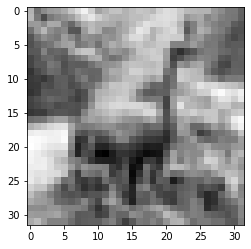

In [27]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

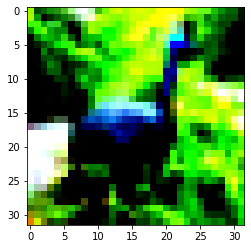

In [28]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

Izlaz iz konvolucionog sloja i odgovarajuca ulazna slika

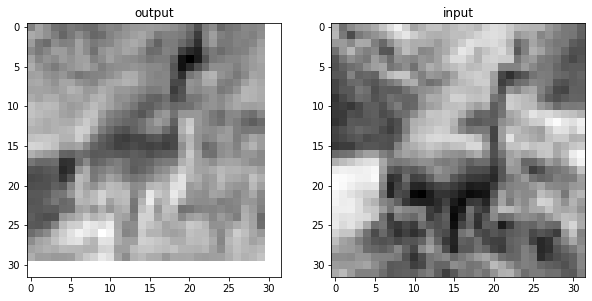

In [ ]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

# **Padding**

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

Ručno postavljanje težina i biasa

In [ ]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

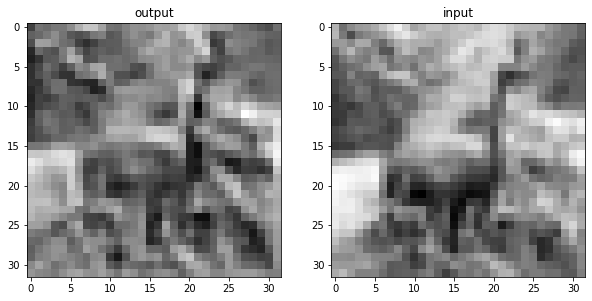

In [ ]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

Ovakav kernel može poslužiti za detekciju ivica

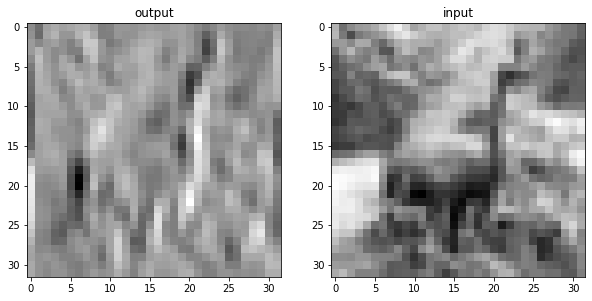

In [ ]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

# **Pooling slojevi**

downsampling

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

The first convolution takes us from 3 RGB channels to 16, thereby giving the network a chance to generate 16 independent features that operate to (hopefully) discriminate low-level features of birds and airplanes. Then we apply the Tanh activation function.
The resulting 16-channel 32 × 32 image is pooled to a 16-channel 16 × 16 image
by the first MaxPool2d. At this point, the downsampled image undergoes another convolution that generates an 8-channel 16 × 16 output. With any luck, this output will consist of higher-level features. Again, we apply a Tanh activation and then pool to an 8-channel 8 × 8 output.
Where does this end? After the input image has been reduced to a set of 8 × 8 features, we expect to be able to output some probabilities from the network that we can feed to our negative log likelihood. However, probabilities are a pair of numbers in a 1D vector (one for airplane, one for bird), but here we’re still dealing with multichannel 2D features. We need to
do: turn the 8-channel 8 × 8 image into a 1D vector and complete our network with a set of fully connected layers:

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1> Warning: Something important is missing here!
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

Let’s first notice that the size of the linear layer is dependent on the expected size of the output of MaxPool2d: 8 × 8 × 8 = 512. Let’s count the number of parameters for this small model.

In [ ]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
model(img.unsqueeze(0))

RuntimeError: ignored

What’s missing there is the reshaping step from an 8-channel 8 × 8 image to a 512-element, 1D vector (1D if we ignore the batch dimension, that is). This could be achieved by calling view on the output of the last nn.MaxPool2d, but unfortunately, we don’t have any explicit visibility of the output of each module when we use nn.Sequential

In [36]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1> This reshape is what we were missing earlier.
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

# If there is any situation that you don't know how many rows you want but are sure of the number of columns, then you can specify this with a -1.
# (Note that you can extend this to tensors with more dimensions. Only one of the axis value can be -1). 
# This is a way of telling the library: "give me a tensor that has these many columns and you compute the appropriate number of rows that is necessary to make this happen".


# The Net class is equivalent to the nn.Sequential model we built earlier in terms of submodules; but by writing the forward function explicitly, we can manipulate the
# output of self.pool3 directly and call view on it to turn it into a B × N vector. Note that we leave the batch dimension as –1 in the call to view, since in principle we
# don’t know how many samples will be in the batch.

# The self.modules() method returns an iterable (An object that can be iterated over) to the many layers or “modules” defined in the model class. This particular piece of code is using that self.modules() 
# iterable to initialize the weights of the different layers present in the model. isinstance() checks if the particular layer “m” is an instance of a conv2d or linear
# or conv3d layer etc. and initializes the weights accordingly.

In [37]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Aktivacione funkcije i pooling slojevi mogu se pozvati direktno iz forward() funkcije. 

In [40]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [39]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0633,  0.0084]], grad_fn=<AddmmBackward0>)

In [41]:
import datetime  # <1> Uses the datetime module included with Python

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2> Our loop over the epochs, numbered from 1 to n_epochs rather than starting at 0
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3> Loops over our dataset in the batches the data loader creates for us
            
            outputs = model(imgs)  # <4> Feeds a batch through our model
            
            loss = loss_fn(outputs, labels)  # <5> and computes the loss we wish to minimize

            optimizer.zero_grad()  # <6> After getting rid of we wish to minimize the gradients from the last round
            
            loss.backward()  # <7> … performs the backward step. That is, we compute the gradients of all parameters we want the network to learn.
            
            optimizer.step()  # <8> Updates the model

            loss_train += loss.item()  # <9> Sums the losses we saw over the epoch. Recall that it is important to transform the loss to a Python number with .item(), to escape the gradients.

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10> Divides by the length of the training data loader to get the average loss per batch. This is a much more intuitive measure than the sum.

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2> Instantiates our network
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-11-15 17:16:25.366084 Epoch 1, Training loss 0.5640485990958609
2022-11-15 17:16:56.992197 Epoch 10, Training loss 0.3276103361017385
2022-11-15 17:17:31.992229 Epoch 20, Training loss 0.30308508635706205
2022-11-15 17:18:04.100645 Epoch 30, Training loss 0.28103280508783973
2022-11-15 17:18:36.400512 Epoch 40, Training loss 0.26124278565121306
2022-11-15 17:19:07.935629 Epoch 50, Training loss 0.24403286393091178
2022-11-15 17:19:41.882418 Epoch 60, Training loss 0.22486522926646432
2022-11-15 17:20:12.814111 Epoch 70, Training loss 0.20538333746468185
2022-11-15 17:20:43.086232 Epoch 80, Training loss 0.18894862302928972
2022-11-15 17:21:14.389075 Epoch 90, Training loss 0.17472834078369626
2022-11-15 17:21:45.679233 Epoch 100, Training loss 0.16142001012518148


In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1> We do not want gradients here, as we will not want to update the parameters.
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2> Gives us the index of the highest value as output
                total += labels.shape[0]  # <3> Counts the number of examples, so total is increased by the batch size
                correct += int((predicted == labels).sum())  # <4> Comparing the predicted class that had the maximum probability and the ground-truth labels, we first get a Boolean array. Taking the
                                                            # sum gives the number of items in the batch where the prediction and ground truth agree.

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.59
Accuracy val: 0.60


In [ ]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt') # .pt PyTorch extension

In [ ]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-11-15 17:26:04.041983 Epoch 1, Training loss 0.5758680332997802
2022-11-15 17:26:07.577937 Epoch 10, Training loss 0.325716264878109
2022-11-15 17:26:11.098573 Epoch 20, Training loss 0.29017593474334974
2022-11-15 17:26:14.664853 Epoch 30, Training loss 0.2672653036892034
2022-11-15 17:26:18.202756 Epoch 40, Training loss 0.2480833184472315
2022-11-15 17:26:21.678083 Epoch 50, Training loss 0.2297151526732809
2022-11-15 17:26:25.210446 Epoch 60, Training loss 0.21523520658919765
2022-11-15 17:26:29.096630 Epoch 70, Training loss 0.1996083552622871
2022-11-15 17:26:32.690692 Epoch 80, Training loss 0.18543457379861242
2022-11-15 17:26:36.192295 Epoch 90, Training loss 0.16809932930264504
2022-11-15 17:26:39.718760 Epoch 100, Training loss 0.15632575225962955


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.89


In [ ]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

In [ ]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2022-11-15 17:27:33.039481 Epoch 1, Training loss 0.5593291232540349
2022-11-15 17:27:36.676486 Epoch 10, Training loss 0.318468005224398
2022-11-15 17:27:40.692350 Epoch 20, Training loss 0.27620849089258037
2022-11-15 17:27:44.669783 Epoch 30, Training loss 0.23905769232541893
2022-11-15 17:27:48.622314 Epoch 40, Training loss 0.20703660478447652
2022-11-15 17:27:52.616241 Epoch 50, Training loss 0.17928825062551315
2022-11-15 17:27:56.545944 Epoch 60, Training loss 0.1546643555259249
2022-11-15 17:28:00.520768 Epoch 70, Training loss 0.13189145002015837
2022-11-15 17:28:04.499623 Epoch 80, Training loss 0.11069143034375398
2022-11-15 17:28:08.477067 Epoch 90, Training loss 0.09151023077025155
2022-11-15 17:28:12.489142 Epoch 100, Training loss 0.07480941127961988
Accuracy train: 0.97
Accuracy val: 0.90


{'train': 0.9738, 'val': 0.8975}

In [ ]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-11-15 17:28:20.110139 Epoch 1, Training loss 0.5685800968841382
2022-11-15 17:28:23.687301 Epoch 10, Training loss 0.3152166673332263
2022-11-15 17:28:28.230443 Epoch 20, Training loss 0.2709067245577551
2022-11-15 17:28:32.190330 Epoch 30, Training loss 0.23598716868336794
2022-11-15 17:28:36.161760 Epoch 40, Training loss 0.20802120631857282
2022-11-15 17:28:40.468037 Epoch 50, Training loss 0.18406066531018847
2022-11-15 17:28:44.449260 Epoch 60, Training loss 0.16069793269322935
2022-11-15 17:28:48.452893 Epoch 70, Training loss 0.1376234822829438
2022-11-15 17:28:52.401144 Epoch 80, Training loss 0.11567694048403175
2022-11-15 17:28:56.350819 Epoch 90, Training loss 0.0957430151000524
2022-11-15 17:29:00.303007 Epoch 100, Training loss 0.07790333521404084
Accuracy train: 0.97
Accuracy val: 0.88


In [ ]:
sum(p.numel() for p in model.parameters())

38386

In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [ ]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-11-15 17:29:09.720424 Epoch 1, Training loss 0.5981719611556666
2022-11-15 17:29:13.923142 Epoch 10, Training loss 0.37438449168660837
2022-11-15 17:29:18.638056 Epoch 20, Training loss 0.3343516144972698
2022-11-15 17:29:23.347524 Epoch 30, Training loss 0.30819303404753373
2022-11-15 17:29:28.094902 Epoch 40, Training loss 0.28818416680879655
2022-11-15 17:29:32.864780 Epoch 50, Training loss 0.27205890198801735
2022-11-15 17:29:37.629960 Epoch 60, Training loss 0.2580151723068991
2022-11-15 17:29:42.351604 Epoch 70, Training loss 0.24552458880623435
2022-11-15 17:29:47.050446 Epoch 80, Training loss 0.23417215177397818
2022-11-15 17:29:51.713130 Epoch 90, Training loss 0.22390416535032784
2022-11-15 17:29:56.674381 Epoch 100, Training loss 0.2141536938346875
Accuracy train: 0.92
Accuracy val: 0.89


In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-11-15 17:30:03.133360 Epoch 1, Training loss 0.5780785789914952
2022-11-15 17:30:06.982015 Epoch 10, Training loss 0.37727662360971903
2022-11-15 17:30:11.188575 Epoch 20, Training loss 0.35059771046137356
2022-11-15 17:30:15.384943 Epoch 30, Training loss 0.33268910504070814
2022-11-15 17:30:19.621086 Epoch 40, Training loss 0.31542556642726727
2022-11-15 17:30:23.843155 Epoch 50, Training loss 0.30374598560059907
2022-11-15 17:30:28.039100 Epoch 60, Training loss 0.2902673084265108
2022-11-15 17:30:32.296215 Epoch 70, Training loss 0.28505776471393124
2022-11-15 17:30:36.515459 Epoch 80, Training loss 0.2701677619271977
2022-11-15 17:30:40.761092 Epoch 90, Training loss 0.260810862680909
2022-11-15 17:30:44.961619 Epoch 100, Training loss 0.24013691200951862
Accuracy train: 0.90
Accuracy val: 0.88


In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-11-15 17:30:51.759178 Epoch 1, Training loss 0.45454358086464514
2022-11-15 17:30:56.003597 Epoch 10, Training loss 0.26562948629354977
2022-11-15 17:31:00.885915 Epoch 20, Training loss 0.20091098779515856
2022-11-15 17:31:05.556080 Epoch 30, Training loss 0.15040757369463612
2022-11-15 17:31:10.313737 Epoch 40, Training loss 0.10733950549772212
2022-11-15 17:31:15.220846 Epoch 50, Training loss 0.07104586291417575
2022-11-15 17:31:19.896952 Epoch 60, Training loss 0.04627759089681563
2022-11-15 17:31:24.598252 Epoch 70, Training loss 0.0619097297216297
2022-11-15 17:31:29.299709 Epoch 80, Training loss 0.017446089719843332
2022-11-15 17:31:34.294078 Epoch 90, Training loss 0.011087907131191841
2022-11-15 17:31:38.999426 Epoch 100, Training loss 0.007507557423109082
Accuracy train: 0.99
Accuracy val: 0.88


In [ ]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2022-11-15 17:31:44.976660 Epoch 1, Training loss 0.6773902443563862
2022-11-15 17:31:48.779110 Epoch 10, Training loss 0.3454795070704381
2022-11-15 17:31:53.008961 Epoch 20, Training loss 0.29759116024728033
2022-11-15 17:31:57.274277 Epoch 30, Training loss 0.2670744237056963
2022-11-15 17:32:01.539524 Epoch 40, Training loss 0.23865249705542424
2022-11-15 17:32:05.728341 Epoch 50, Training loss 0.2097036264314773
2022-11-15 17:32:09.917312 Epoch 60, Training loss 0.1821163156229979
2022-11-15 17:32:14.134916 Epoch 70, Training loss 0.15608544194489526
2022-11-15 17:32:18.345574 Epoch 80, Training loss 0.13097528282813964
2022-11-15 17:32:22.561296 Epoch 90, Training loss 0.10648473462528864
2022-11-15 17:32:27.117843 Epoch 100, Training loss 0.08537968061864376
Accuracy train: 0.93
Accuracy val: 0.88


In [ ]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2022-11-15 17:32:27.815031 Epoch 1, Training loss 0.6149618682587982
2022-11-15 17:32:31.713345 Epoch 10, Training loss 0.3252342461021083
2022-11-15 17:32:36.023390 Epoch 20, Training loss 0.2761269767003454
2022-11-15 17:32:40.312975 Epoch 30, Training loss 0.24012756993056864
2022-11-15 17:32:44.574175 Epoch 40, Training loss 0.20635571819581802
2022-11-15 17:32:48.826513 Epoch 50, Training loss 0.17677883808590045
2022-11-15 17:32:53.064677 Epoch 60, Training loss 0.14908850242852406
2022-11-15 17:32:57.305389 Epoch 70, Training loss 0.12247129880888447
2022-11-15 17:33:01.529318 Epoch 80, Training loss 0.09602260149445883
2022-11-15 17:33:05.767838 Epoch 90, Training loss 0.07334165677285878
2022-11-15 17:33:09.997487 Epoch 100, Training loss 0.059634673100700426
Accuracy train: 0.97
Accuracy val: 0.90


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [ ]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-11-15 17:33:19.155346 Epoch 1, Training loss 1.4803008397293698
2022-11-15 17:34:39.224369 Epoch 10, Training loss 0.28240926924404824
2022-11-15 17:36:07.899808 Epoch 20, Training loss 0.21208198601083392
2022-11-15 17:37:36.905709 Epoch 30, Training loss 0.13147530768802212
2022-11-15 17:39:05.495876 Epoch 40, Training loss 0.13600497400969458
2022-11-15 17:40:33.995260 Epoch 50, Training loss 0.09120933080364944
2022-11-15 17:42:02.725608 Epoch 60, Training loss 0.06872567600885014
2022-11-15 17:43:33.487283 Epoch 70, Training loss 0.10712844052701999
2022-11-15 17:45:02.906004 Epoch 80, Training loss 0.09124359017042265
2022-11-15 17:46:31.408557 Epoch 90, Training loss 0.0456588034874724
2022-11-15 17:48:00.161045 Epoch 100, Training loss 0.04474980441800016
Accuracy train: 0.98
Accuracy val: 0.87


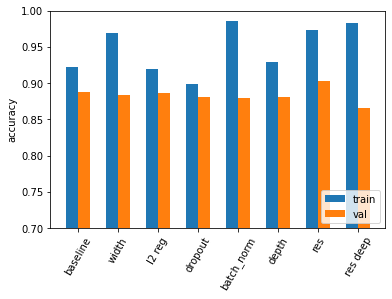

In [ ]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()